# Create setup file for Xana code
Input: mask file (see '01_CreateMask.ipynb'), q ROIs, setup parameters of beam line 

Output: pickle file with setup for Xana code

In [1]:
%matplotlib notebook
%pylab
# %matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import os
from Xana import Xana
from matplotlib.colors import LogNorm

from GetConfiguration import GetConfiguration # separate code for extracting beam line parameters from P10s .fio files

import pandas
import pickle as pkl
import configparser as configparser
import ast

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


blosc filter already loaded, skip it.
bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.
zstd filter already loaded, skip it.
fcidecomp filter already loaded, skip it.


In [2]:
sample = 'm029_eggwhite_70C_bd' # name of the sample
series = 1                 # number of series that will be loaded
rawdir = '../../raw'       # path to raw directory, add or remove '../' depending on where you are in the folder tree
fmtstr = 'p10_eiger_h5'    # string for file format, does not need to be changed for analyzing P10 data

dataFolder,detector,distance,pixelSize,pulseEnergy,centerX,centerY = GetConfiguration(sample,series,rawdir) #load data folder and detector identifier

maskfile = 'e4m_mask.npy' # enter name of mask that you want to use (needs to match the size of the detector)
setup = 'USAXS_e4m_12q' # enter name of the setup that you are goint to create




In [3]:
d = Xana(sample=sample, fmtstr=fmtstr, detector=detector,maskfile=maskfile) #create Xana object
d.connect(rawdir+'/'+sample+'_000{:02d}/'.format(series)+dataFolder) #connect Xana object to data folder
d.meta  #look into meta data, if no table is appearing, check the path

,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir
0,1,0,0.50001,0.5,0.00001,2000,0,1999,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...,/asap3/petra3/gpfs/p10/2022/data/11015476/raw/...


In [4]:
meanIntensity, varIntensity = d.get_series(0, #choose entry from table above
                                           verbose=1, #amout of output displayed
                                           method='average' #intensity will be averaged over all frames
                                          ) 

H5 file using external links.
First images is:  0
Last image is:  1999
Loading data in chunks of 200 images.
[============================================================] 100.0%...


<IPython.core.display.Javascript object>


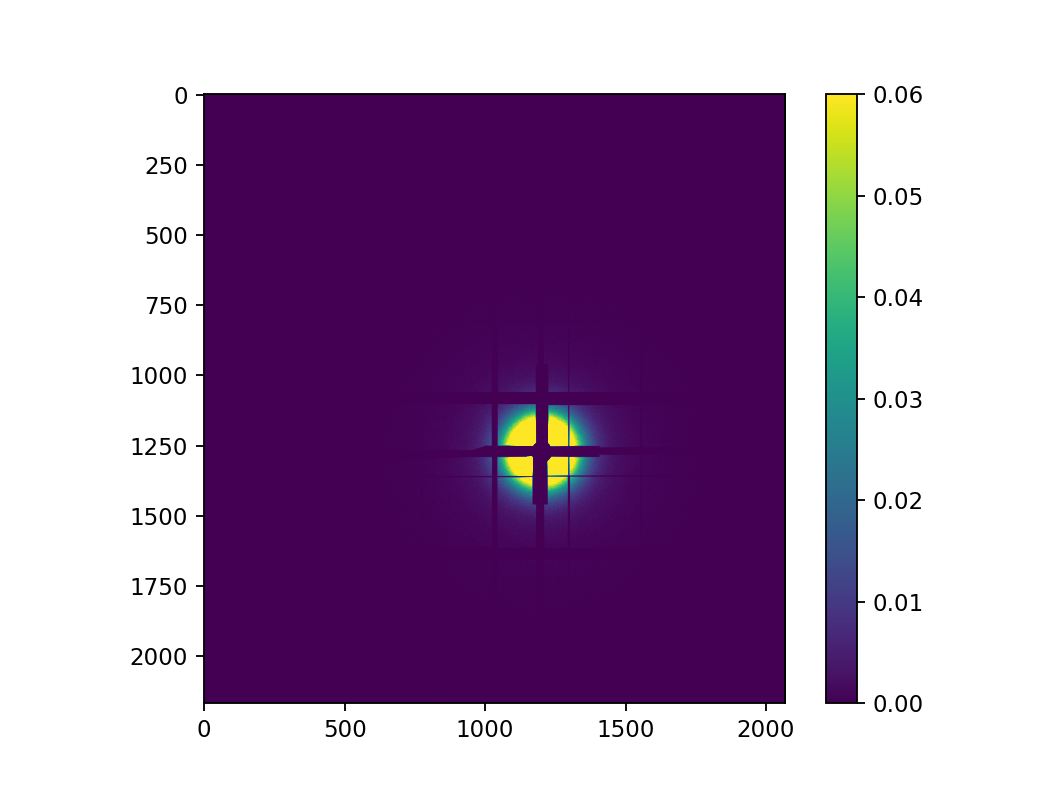

In [5]:
#display masked meanIntensity to ensure that there is intensity in the selected frames
fig, ax = plt.subplots()
mask = np.load(maskfile)
im = ax.imshow(np.multiply(meanIntensity,mask),vmax=0.06)
plt.colorbar(im)

## Define q ring setup

Added the following Q-values [nm-1]:
[0.006 0.008 0.01  0.012 0.014 0.02  0.03  0.04  0.05  0.06  0.07  0.08 ]


<IPython.core.display.Javascript object>


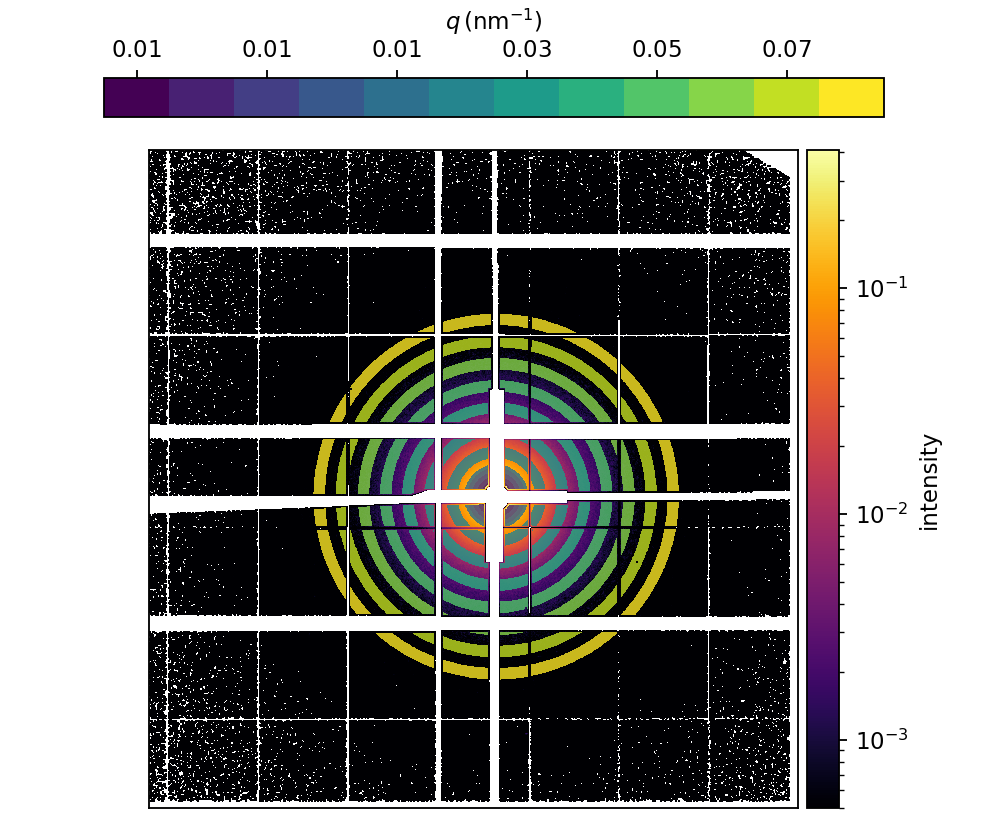

In [6]:
d.setup.make(**{'wavelength':np.divide(12.398,pulseEnergy/1000), #incident wavelength in Angstrom
                'center':(centerX,centerY), #coordinates of the center of the direct beam in pixels
                'pixel_size':(pixelSize*1000,pixelSize*1000), #pixel size in micrometers
                'distance':distance/1000, #sample-detector distance in meters
               }
            )            

qv_init = [(np.arange(0.006, 0.016, 0.002), 0.002), #syntax (start q value, end q value, step), width of q-ring
          (np.arange(0.02, 0.081, 0.01), 0.006),
          ]#e4m_xpcs_largeq 

d.defineqrois(meanIntensity, #2D array with masked intensity
              qv_init=qv_init, #definition of q ROIs
              plot=2, #1: 1d plot with azimuthally integrated intensity, 2: 2d plot with view of the detector
              d=1000, #zoom in and out of plot
             )

In [7]:
d.mksavdir('setupfiles', './') # setup will be saved in directory setupfiles
d.savesetup(setup) # save setup

Changing savdir to:
	/asap3/petra3/gpfs/p10/2022/data/11015476/processed/tests/setupfiles/
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11015476/processed/tests/setupfiles/analysis_database.pkl
Initialize database...

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11015476/processed/tests/setupfiles/analysis_database.pkl

Results saved to:
	/asap3/petra3/gpfs/p10/2022/data/11015476/processed/tests/setupfiles/USAXS_e4m_12q.pkl


# Show setup file

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle as pkl

def GetSetup(setupfile = './setupfiles/example_setup.pkl'):
    setupFile = open(setupfile,'rb') # open pickle file
    setupParams = pkl.load(setupFile) # load file content
    setupFile.close() # close pickle file
    
    qValues = setupParams.qv #all properties are listed under https://github.com/reiserm/Xana/blob/master/Xana/Setup.py
    maskFile = setupParams.maskfile
    beamCenter = setupParams.center
    qRoi = setupParams.qroi
    
    return([qValues,maskFile,qRoi,beamCenter])

def add_colorbar(ax, vec, label=None): #add colorbar to axis ax that with a color range from vec.min() to vec.max()
    vec = np.array(vec)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cmap = mpl.cm.viridis # choose color map for colorbar
    norm = mpl.colors.Normalize(vmin=vec.min(), vmax=vec.max()) 

    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
    cb1.set_label(label) # add label to axis

In [9]:
setup = 'USAXS_e4m_12q' # give name of existing setup

In [10]:
qValues,maskfile,qRois,beamCenter = GetSetup('./setupfiles/'+setup+'.pkl') # extract information from existing setup
mask = np.load(maskfile) # load mask from maskfile

In [11]:
qMasks = np.zeros([len(qValues),mask.shape[0],mask.shape[1]]) # 3d array for adding entries per q value for 2d representation
for q in range(len(qRois)): # loop over q ROIs
    temp_roi = qRois[q] 
    num_pix = len(qRois[q][0]) # number of pixels in the q ROI

    for j in range(num_pix): # loop over pixels in q ROI
        x = temp_roi[0][j] # extract coordinates
        y = temp_roi[1][j]
        qMasks[q,x,y] = q+1 # add 1 for first q ROI, 2 for second etc.


In [12]:
qMasksSum = np.sum(qMasks,axis=0) # sum over array for 2d representation, needs to be adapted for overlapping q ROIs

<IPython.core.display.Javascript object>


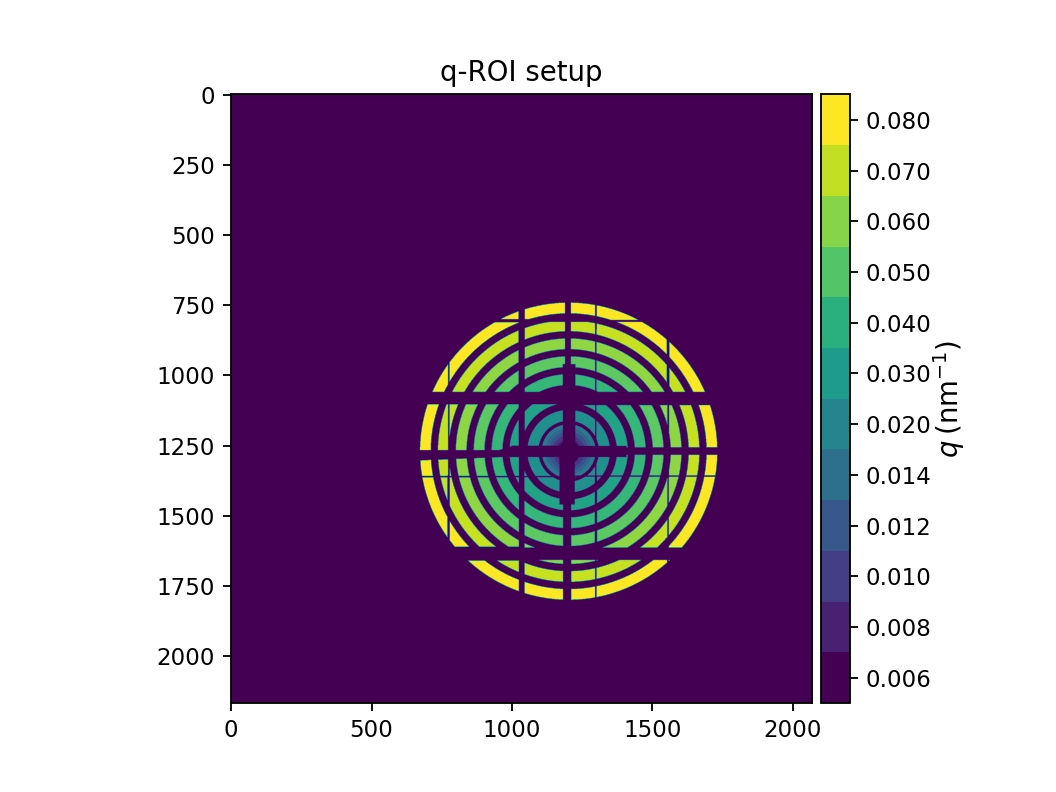

In [13]:
from matplotlib.colors import ListedColormap # package for segmented colorbar

fig, ax = plt.subplots()
ax.imshow(qMasksSum,cmap = mpl.cm.viridis)
ax.set_title('q-ROI setup')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05) # add axis for colorbar

colors=plt.cm.viridis(np.linspace(0,1,12))


cmap = ListedColormap([colors[i] for i in range(12)])
norm = mpl.colors.Normalize(vmin=0,vmax=12)
cb0a = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
cb0a.set_ticks(np.arange(0.5,13,1))
cb0a.set_ticklabels(['{:.3f}'.format(qValues[i]) for i in range(12)])
cb0a.set_label('$q\:\mathrm{(nm^{-1})}$',fontsize=12,labelpad=0)
